# Rachaduras

In [1]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image

def load_model(
    model_name="runwayml/stable-diffusion-inpainting",
    dtype=torch.float16,
    device="cuda"
):
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_name,
        torch_dtype=dtype,
        safety_checker=None
    )
    pipe = pipe.to(device)
    pipe.enable_attention_slicing()
    # pipe.enable_xformers_memory_efficient_attention()
    return pipe

def refine_image(pipe, image, mask, prompt, negative="", strength=0.8, guidance=7.5):
    out = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=image,
        mask_image=mask,
        strength=strength,
        guidance_scale=guidance
    ).images[0]
    return out

def dilate_mask(mask, kernel_size=15, iterations=1):
    mask_np = np.array(mask.convert("L"))
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(mask_np, kernel, iterations=iterations)
    return Image.fromarray(dilated)

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


# Imagens

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io

def upload_image():
    uploaded = files.upload()
    filename = next(iter(uploaded))
    return Image.open(io.BytesIO(uploaded[filename]))

def save_image(img, path):
    img.save(path)

def show_image(img, figsize=(6,6), cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    plt.show()

def overlay_mask(image, mask, color=(255,0,0), alpha=0.5):
  image = image.convert("RGBA")
  mask = mask.convert("L")
  overlay = Image.new("RGBA", image.size, color + (0,))
  overlay.putalpha(mask.point(lambda p: int(p*alpha)))
  return Image.alpha_composite(image, overlay)

# Máscara

In [16]:
def detect_cracks(pil_img, kernel_size=15, threshold_factor=0.9):
    img = np.array(pil_img.convert("L"))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)

    tophat_norm = cv2.normalize(tophat, None, 0, 255, cv2.NORM_MINMAX)

    otsu_thresh, _ = cv2.threshold(
        tophat_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    final_thresh = int(otsu_thresh * threshold_factor)

    _, binary = cv2.threshold(tophat_norm, final_thresh, 255, cv2.THRESH_BINARY)

    return binary

def refine_mask(mask):
  num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)
  areas = stats[:, cv2.CC_STAT_AREA]

  min_area = 180

  mask = np.zeros_like(mask)
  for i in range(1, num_labels):
      if areas[i] > min_area:
          mask[labels == i] = 255

  mask = cv2.dilate(mask, np.ones((3,3), np.uint8))
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((1,1), np.uint8))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
  mask = cv2.GaussianBlur(mask, (7,7), 0)

  return mask

def join_images(image, refined_image, mask):
  image_np = np.array(image)
  refined_image_np = np.array(refined_image)
  mask_np = np.array(mask)

  h, w = image_np.shape[:2]

  refined_resized = cv2.resize(refined_image_np, (w, h), interpolation=cv2.INTER_LINEAR)
  mask_resized = cv2.resize(mask_np, (w, h), interpolation=cv2.INTER_NEAREST)

  mask_3ch = np.stack([mask_resized/255]*3, axis=-1)

  final = (refined_resized * mask_3ch + image_np * (1 - mask_3ch)).astype(np.uint8)

  return final


# Fundo

In [4]:
!pip install mediapipe

import cv2
import mediapipe as mp
def get_background(image):
    mp_selfie = mp.solutions.selfie_segmentation
    segmenter = mp_selfie.SelfieSegmentation(model_selection=1)

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = segmenter.process(rgb)
    mask = result.segmentation_mask

    _, mask = cv2.threshold(mask, 0.7, 255, cv2.THRESH_BINARY)
    mask = mask.astype('uint8')

    mask = cv2.bitwise_not(mask)

    return mask

def inpaint_background(image, mask):
  return cv2.inpaint(image.astype(np.uint8), mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)


# Super Resolution

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Saving 4-out.png to 4-out (1).png


  0%|          | 0/25 [00:00<?, ?it/s]

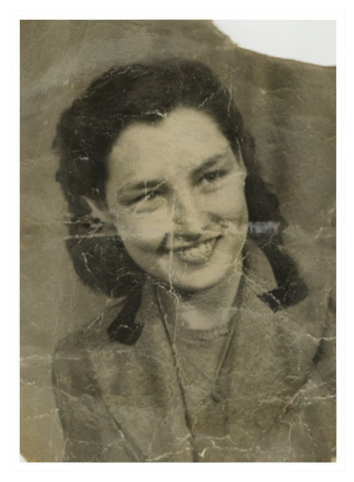

In [6]:
# !pip install diffusers transformers accelerate safetensors torch --quiet
# !pip install opencv-python-headless scikit-image pillow matplotlib numpy --quiet

import os
from PIL import Image
import torch
from diffusers import StableDiffusionUpscalePipeline
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe_superres = StableDiffusionUpscalePipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
)
pipe_superres = pipe_superres.to(device)
pipe_superres.enable_model_cpu_offload()
pipe_superres.enable_sequential_cpu_offload()

def upscale_diffusion(
    img: Image.Image,
    prompt=(
        "ultra detailed, photorealistic enhancement, natural skin, "
        "accurate geometry, sharp textures, clean colors, restore fine detail"
    ),
    negative_prompt=(
        "blurry, distorted face, artifacts, plastic skin, noise, "
        "over-sharpened, texture repetition"
    ),
    steps=25,
    scale=5.0
):
    pipe_superres.enable_vae_tiling()
    pipe_superres.enable_attention_slicing()

    with torch.inference_mode():
        out = pipe_superres(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=img,
            num_inference_steps=steps,
            guidance_scale=scale
        )
    return out.images[0]

image = upload_image()

image = image.convert("RGB")

result = upscale_diffusion(image)

show_image(result)

# Pipeline

Saving a355db95aecf9f9f05f6b3dcdbc92c53.jpg to a355db95aecf9f9f05f6b3dcdbc92c53 (7).jpg


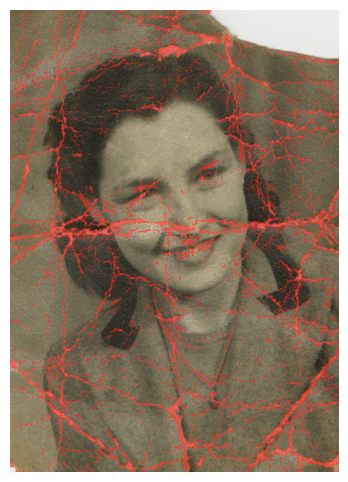

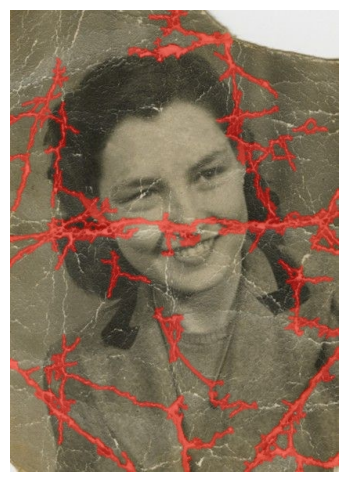

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

  0%|          | 0/40 [00:00<?, ?it/s]

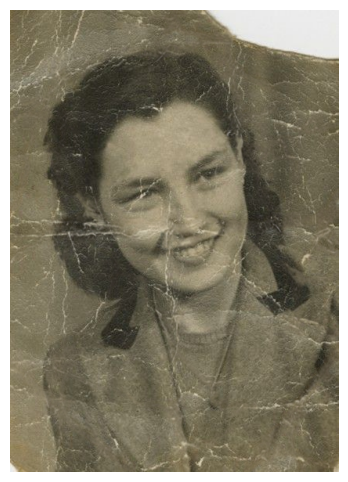

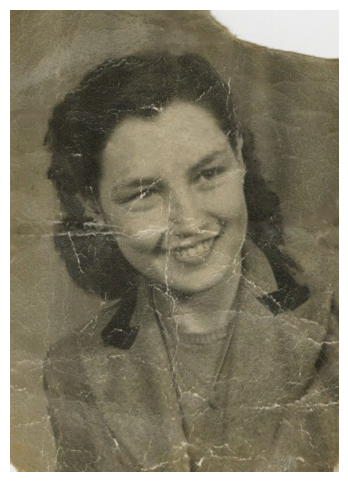

In [19]:
import numpy as np
import cv2
from PIL import Image

import numpy as np
import cv2
from PIL import Image
import os

def restore(image, output_path):

  # 1. detectar máscara (grosseira)
  mask = detect_cracks(image, threshold_factor=0.85, kernel_size=10)

  overlay = overlay_mask(image, Image.fromarray(mask), color=(255,0,0), alpha=0.5)

  show_image(overlay)

  # # 2. refinar máscara (remover falsos positivos, tipo dentes)
  mask = refine_mask(mask)

  overlay = overlay_mask(image, Image.fromarray(mask), color=(255,0,0), alpha=0.5)

  show_image(overlay)

  # 3. inpainting usando máscara
  pipe = load_model()

  refined_image = refine_image(
      pipe=pipe,
      image=image,
      mask=mask,
      prompt="realistic human face, maintain original facial features, smooth skin, natural lighting, extremely high detail, ultra-realistic eyes, nose, mouth, hair, preserve identity, remove scratches and damage, high quality, sharp, photorealistic, subtle enhancement only",
      negative="distorted face, melted features, deformed, low quality, blur, artifacts, unrealistic",
      strength=0.8,
      guidance=7
  )

  # 4. juntar imagem refinada + imagem original
  inpainted = join_images(image, refined_image, mask)

  show_image(inpainted)

  # 5. background

  background = get_background(np.array(image.convert("L")))
  mask = detect_cracks(image)
  background_cracks = cv2.bitwise_and(mask, background)

  refined_background = inpaint_background(inpainted, background_cracks)

  show_image(Image.fromarray(refined_background))

  save_image(Image.fromarray(refined_background), output_path)

os.makedirs("outputs", exist_ok=True)

uploaded = files.upload()

for filename, data in uploaded.items():
    image = Image.open(io.BytesIO(data)).convert("RGB")
    output_path = f"outputs/{filename.rsplit('.',1)[0]}_out.png"
    restore(image, output_path)


# Teste

In [ ]:
from google.colab import files
import os

uploaded = files.upload()

os.makedirs("imagens", exist_ok=True)

for nome_arquivo in uploaded.keys():
    caminho = os.path.join("imagens", nome_arquivo)
    with open(caminho, "wb") as f:
        f.write(uploaded[nome_arquivo])


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# def detect_cracks(pil_img, blur=3, canny_thresh1=50, canny_thresh2=150):
#     img = np.array(pil_img.convert("L"))
#     img_blur = cv2.GaussianBlur(img, (blur, blur), 0)
#     edges = cv2.Canny(img_blur, canny_thresh1, canny_thresh2)
#     return edges


def overlay_mask(image, mask, color=(255,0,0), alpha=0.5):
    image_np = np.array(image).copy()
    mask_rgb = np.zeros_like(image_np)
    mask_rgb[mask>0] = color
    overlay = cv2.addWeighted(image_np, 1, mask_rgb, alpha, 0)
    return Image.fromarray(overlay)

def refine_mask(mask):
  num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)
  areas = stats[:, cv2.CC_STAT_AREA]

  min_area = 180

  mask = np.zeros_like(mask)
  for i in range(1, num_labels):
      if areas[i] > min_area:
          mask[labels == i] = 255

  mask = cv2.dilate(mask, np.ones((3,3), np.uint8))
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((1,1), np.uint8))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
  mask = cv2.GaussianBlur(mask, (7,7), 0)

  return mask

pasta_imagens = "imagens"
imagens_files = [os.path.join(pasta_imagens, f) for f in os.listdir(pasta_imagens)]

overlays = []
overlays_refined = []

for caminho in imagens_files:
    image = Image.open(caminho).convert("RGB")
    mask = detect_cracks(image, threshold_factor=0.999, kernel_size=10)
    refined_mask = refine_mask(mask)

    overlay_refined = overlay_mask(image, refined_mask, color=(255,0,0), alpha=0.5)
    overlay = overlay_mask(image, mask, color=(255,0,0), alpha=0.5)

    # mask = detectar_rachaduras(np.array(image))
    # overlay = overlay_mask(image, mask, color=(255,0,0), alpha=0.5)
    overlays.append(overlay)
    overlays_refined.append(overlay_refined)

all_rows = [overlays, overlays_refined]
max_len = max(len(overlays), len(overlays_refined))
fig, axes = plt.subplots(2, max_len, figsize=(max_len*4, 8))

for row_idx, row in enumerate(all_rows):
    for col_idx in range(max_len):
        ax = axes[row_idx, col_idx] if max_len > 1 else axes[row_idx]
        ax.axis("off")
        if col_idx < len(row):
            ax.imshow(row[col_idx])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
